# Porto Seguro's Safe Driver Prediction

- 데이터: [Porto Seguro's Safe Driver Prediction](https://www.kaggle.com/competitions/porto-seguro-safe-driver-prediction/data)
- 필사 참조: [Interactive Porto Insights - A Plot.ly Tutorial](https://www.kaggle.com/code/arthurtok/interactive-porto-insights-a-plot-ly-tutorial/notebook)

### Plotly
: Python에서 시각화 할 수 있는 무료 오픈소스 그래프 라이브러리

**장점** <br/>
- Simple horizontal bar plot: Used to inspect the Target variable distribution
- Correlation Heatmap plot: Inspect the correlation between the diffrent features
- Scatter plot: Compare the feature importances generated by Random Forest adn Gradient-Boosted model
- Vertical bar plot: List in Descending order, the importance of the various features
- 3D Scatter plot

**목차** <br/>
1. Data Quality Checks - Visualizing and evaluating all missing/Null values (values that are -1)
2. Feature inspection and filtering (Correlation and feature Mutual information plots against the target variable. Inspection of the Binary, categorical and other variables)
3. Feature importance ranking via learning models (\n Building a Random Forest and Gradient Boosted model to help us rank features based off the learning process)

In [2]:
# !pip install plotly==4.14.1

     |████████████████████████████████| 13.2 MB 7.4 MB/s eta 0:00:01
  Created wheel for retrying: filename=retrying-1.3.3-py3-none-any.whl size=11448 sha256=13557544aa4789e3abdb02b4b14a2e7755da0ef7a30400fe8e9fb7442c67a987
  Stored in directory: /Users/yeon/Library/Caches/pip/wheels/ce/18/7f/e9527e3e66db1456194ac7f61eb3211068c409edceecff2d31
Successfully built retrying


In [3]:
# Let us load in the relevant Python modules
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import warnings
from collections import Counter
from sklearn.feature_selection import mutual_info_classif
warnings.filterwarnings('ignore')

In [4]:
train = pd.read_csv('../data/Porto_Seguro/train.csv')
train.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,...,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,...,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,...,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,...,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,...,3,1,1,3,0,0,0,1,1,0


In [6]:
# Taking a look at how many rows and columns the train dataset contains
rows = train.shape[0]
columns = train.shape[1]
print('The train dataset contains {0} rows adn {1} columns'.format(rows, columns))

The train dataset contains 595212 rows adn 59 columns


## 1. Data Quality Checks
### Null or missing values check
> 모든 값이 다 False = isnull()이 하나도 없다 = 결측치가 하나도 없다.

In [8]:
# any() applied twice to check run the isnull check across *all* columns.
train.isnull().any().any()

False

> - null value가 결국 `False`를 리턴하긴 했지만, 'Values of -1 indicate that the feature was missing from the observation' 이다.
> - 따라서 -1 값을 갖는 value들을 null value로 치환하자.

In [10]:
train_copy = train
train_copy = train_copy.replace(-1, np.NaN)

> `Missingno` 패키지의 창시자인 [Aleksey Bilogur](https://www.kaggle.com/residentmario)를 참조해 missing value를 시각화 할 수 있는 유용하고 편안한 툴을 이용해 확인하자.

In [13]:
# !pip install missingno

<AxesSubplot:>

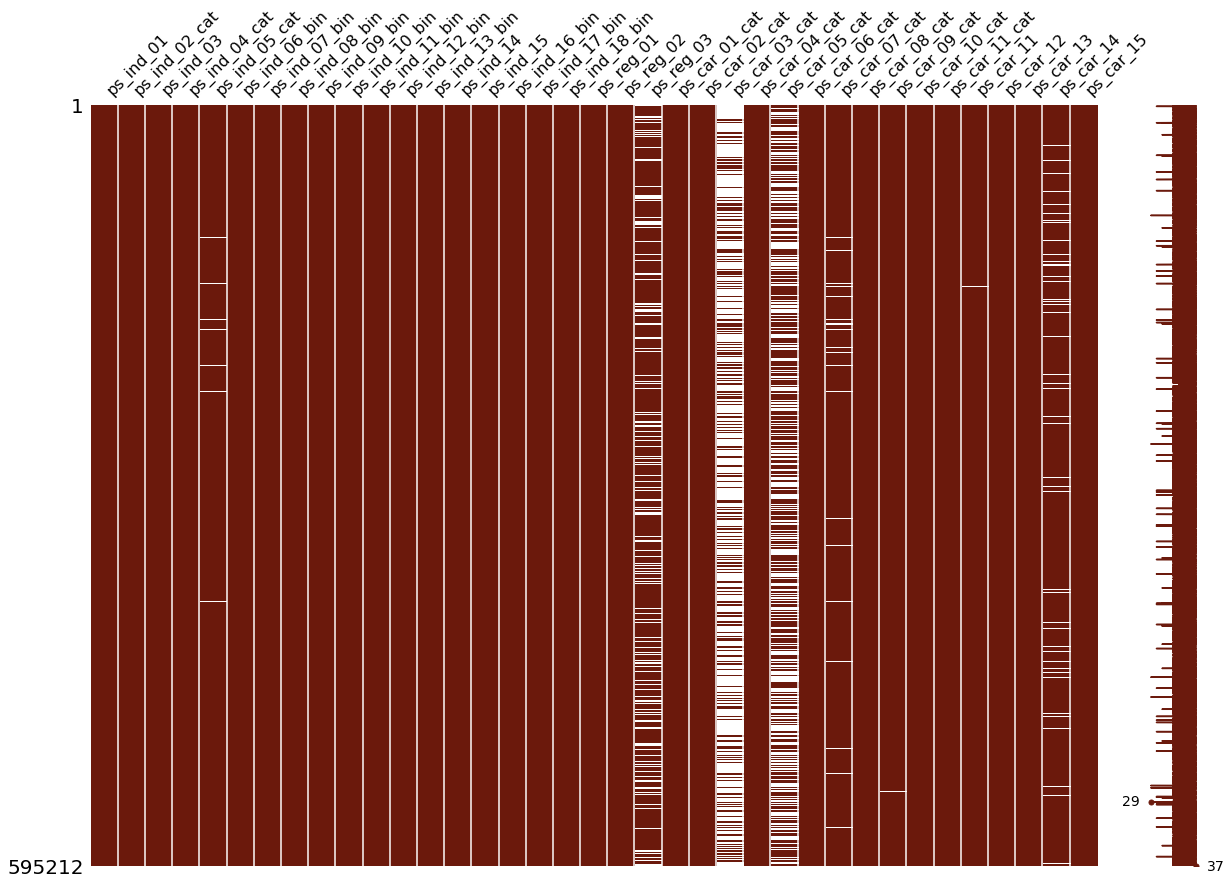

In [14]:
import missingno as msno
# Nullity or missing values by columns
msno.matrix(df=train_copy.iloc[:, 2:39], figsize=(20, 14), color=(0.42, 0.1, 0.05))

> 위에서 볼 수 있듯, missing value들이 더 clear하게 보여진다.
> - 총 59개의 feature(열)이 있었는데 그 중 7개에서 결측치를 발견할 수 있다.
> - 오른쪽 끝엘 보면 feature들이 짤린 것을 볼 수 있는데, 이는 missingno matrix plot이 40개의 odd feature만을 그릴 수 있기 때문이다. 따라서 짤린 나머지 5개 null column을 포함하려면 figsize를 조절해라.

관찰할 수 있는 7개의 null columns는 다음과 같다. <br/>

**ps_ind_05_cat**, **ps_reg_03**, **ps_car_03_cat**, **ps_car_05_cat**, **ps_car_07_cat**, **ps_car_09_cat**, **ps_car_14** <br/>

대부분의 missing value들은 `_cat`으로 끝나는 변수들에서 많이 나타난다. <br/>

`ps_reg_03`, `ps_car_03_cat`, `ps_car_05_cat`에 대해 생각해보자. 위 missingno matrix plot을 보면 이 3개의 column들에 white band가 진하다, 즉 결측치가 많다. -> `-1`을 null로 대체하는 것은 좋은 방법이 아니구나!

#### Target variable inspection

In [15]:
data = [go.Bar(
            x = train['target'].value_counts().index.values,
            y = train['target'].value_counts().values,
            text='Distribution of target variable'
        )]

layout = go.Layout(
    title='Target variable distribution'
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='basic-bar')

> target value가 굉장히 imbalance하다!

### Datatype check